In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc,roc_curve,roc_auc_score
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import save_model

<h2> Data Loading &  Data Processing</h2>

- Load and resize the images to a size of 60 by 60

In [2]:
def read_images(path):
    images = []
    labels = []
    num1 = 50
    num2 = 50
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = plt.imread(file_path + '/' + img_name)
                    new_img = resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 1
                    else:
                        label = 0
                    labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
x, y= read_images('cell_images')
# uninfected_images, uninfected_labels = load_images_from_folder(uninfected_folder)

In [4]:
print("Image Dimension: ", x.shape)
print("Image Dimension: ", y.shape)

Image Dimension:  (27558, 50, 50, 3)
Image Dimension:  (27558,)


Parasitized


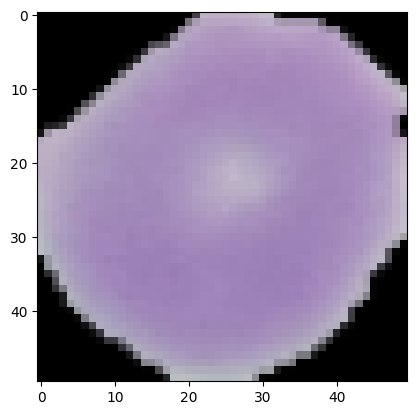

In [5]:
plt.imshow(x[19000])
if y[19000]==1:
   print("Uninfected")
else:
    print("Parasitized") 

Uninfected


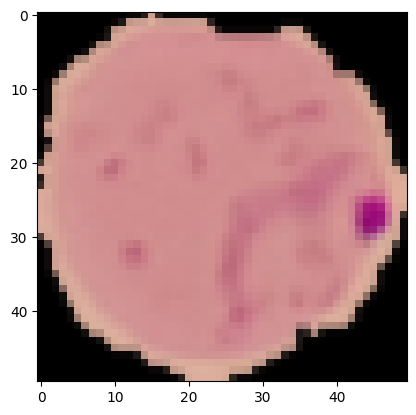

In [6]:
plt.imshow(x[88], cmap='gray')
if y[88]==1:
   print("Uninfected")
else:
    print("Parasitized") 

- extract and flattening the image data to a 2D array

In [12]:
def extract_and_flatten_features(images):

    return np.array([img.flatten() for img in images])

In [17]:
x_flattened = extract_and_flatten_features(x)
x_flattened.shape

(27558, 7500)

<h2>Feature Extraction</h2>

- Filter Method: Information Gain

In [19]:
mi_scores = mutual_info_classif(x_flattened, y)

k = 6000  # Number of top features to select
selector = SelectKBest(mutual_info_classif, k=k)
X_selected = selector.fit_transform(x_flattened, y)

In [20]:
X_selected.shape

(27558, 6000)

- Wrapper Method: SelectFromModel with RandomForest and a mean threshold

In [21]:
sfm = SelectFromModel(LogisticRegression(max_iter=100, penalty='l1',solver='saga'), threshold='mean')

x_final_selected = sfm.fit_transform(X_selected, y)

# Get support mask
support = sfm.get_support()

# Get indices of selected features
selected_indices = np.where(support)[0]
selected_features_sfm = X_selected[:, selected_indices]

In [ ]:
selected_features_sfm.shape

(27558, 2403)

- Normalization: Using MinMaxScaler to scale images to a fixed range, typically between 0 and 1.

In [ ]:
minx = MinMaxScaler()
x_normalized = minx.fit_transform(selected_features_sfm)
x_normalized.shape

(27558, 2403)

- Standardization: scaling the images which transforms data to have a mean of 0 and a standard deviation of 1.

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(selected_features_sfm)
x_scaled.shape

(27558, 2403)

<h2>RBFN Model Development</h2>

- Data Splitting: 80% training, 20% testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

In [ ]:
x_train.shape

(22046, 2403)

- Model building

In [ ]:
rbfn_model = Sequential([
    Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    
    Dense(units=2, activation='softmax')
])

rbfn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │       307,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,610 (1.22 MB)

 Trainable params: 318,610 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rbfn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
epochs = 15
history = rbfn_model.fit(x_train, y_train, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data=(x_test, y_test))


Epoch 1/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9790 - loss: 0.0529 - val_accuracy: 0.8110 - val_loss: 0.9686
Epoch 2/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9877 - loss: 0.0360 - val_accuracy: 0.8084 - val_loss: 1.0707
Epoch 3/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9837 - loss: 0.0495 - val_accuracy: 0.8081 - val_loss: 1.0997
Epoch 4/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9879 - loss: 0.0340 - val_accuracy: 0.8026 - val_loss: 1.1569
Epoch 5/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9861 - loss: 0.0440 - val_accuracy: 0.8104 - val_loss: 1.0670
Epoch 6/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9901 - loss: 0.0296 - val_accuracy: 0.8057 - val_loss: 1.1002
Epoch 7/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9856 - loss: 0.0408 - val_accuracy: 0.8122 - val_loss: 1.0805
Epoch 8/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9908 - loss: 0.0274 - val_acc

<h2>Lstm Model Evaluation</h2>

- Accuracy, Precision, Recall, F1-Score, MSE

In [ ]:
y_pred = rbfn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
mse_score = mean_squared_error(y_test, y_pred_classes)
# Print evaluation metrics
print("Accuracy Score:", accuracy.__round__(2))
print("Precision Score:", precision.__round__(2))
print("Recall Score:", recall.__round__(2))
print("F1-score Score:", f1.__round__(2))
print("MSE Score:", mse_score.__round__(2))

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy Score: 0.81
Precision Score: 0.8
Recall Score: 0.82
F1-score Score: 0.81
MSE Score: 0.19


- Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
conf_matrix

array([[2210,  554],
       [ 504, 2244]], dtype=int64)

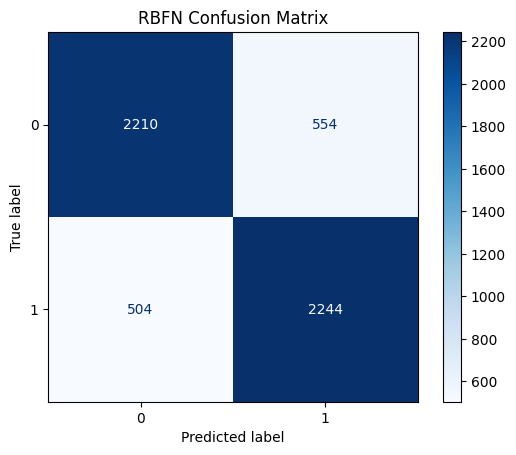

In [ ]:
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title("RBFN Confusion Matrix")
plt.show()

- AUC-ROC

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
AUC ROC Score: 0.884406262046651


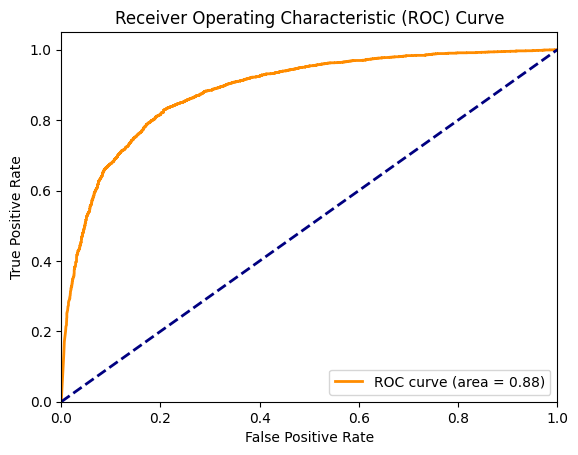

In [ ]:
y_pred_proba = rbfn_model.predict(x_test)[:, 1]  # Probability of the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC ROC Score:', roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model_path = 'rbfn_malaria.h5'
save_model(rbfn_model, model_path)

<h2> Explainable AI techniques using Shapely (SHAP)

In [ ]:
import shap

explainer = shap.KernelExplainer(rbfn_model.predict, x_train[:100])

# calculate shap values
shap_vals = explainer.shap_values(x_test[:10])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


MemoryError: Unable to allocate 6.14 GiB for an array with shape (6854, 240300) and data type float32

In [ ]:
print(shap_vals.shape)
print(x_test.shape)

(10, 2403, 2)
(5512, 2403)


- visualize shap values

In [ ]:
# Ensure that the data types are compatible
explainer_expected_value = np.array(explainer.expected_value, dtype=np.float64)
shap_vals = np.array(shap_vals, dtype=np.float64)
x_test = np.array(x_test, dtype=np.float64)

# Plot the force plot for the first sample and the first output dimension
shap.initjs()
shap.plots.force(explainer_expected_value[0], shap_vals[0][:, 0], x_test[0])

- summary plot to see the global feature importance

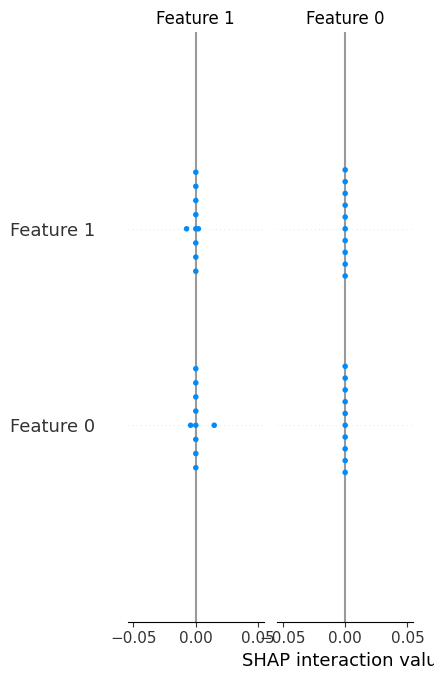

In [ ]:
shap.summary_plot(shap_vals, x_test[:10])